Simple decoder for SPI traces
=============================

The only real command implemented so far is EDh without XIP.

Example `spitrace.csv` file:

```
"time","Ch7","Ch6","IO3","IO2","IO1","IO0","CSB","CLK"
0,0,0,1,1,0,0,0,1
16,0,0,1,1,0,0,0,0
32,0,0,1,1,0,0,0,1
50,0,0,1,1,0,0,0,0
66,0,0,1,1,0,0,0,1
82,0,0,1,1,0,0,0,0
100,0,0,1,1,0,0,0,1
....
```

The time must be the first column. Other columns are identified by header.

Only time and columns "CSB", "CLK", "IO0", "IO1", "IO2", and "IO3" are used. All other columns are ignored.

Adjust the `ddr_delay` parameter in the next cell as needed.

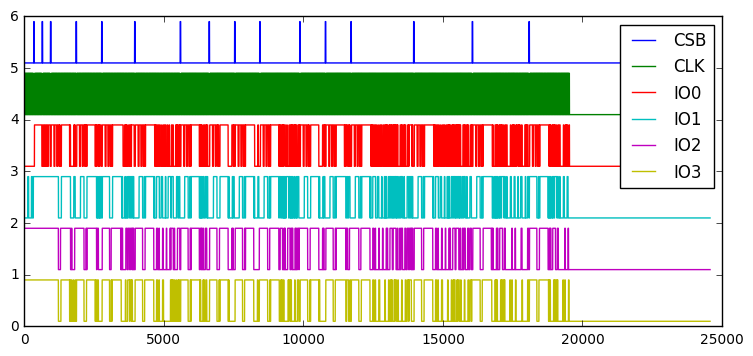

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import struct
import csv

data = list()
cols = ["CSB", "CLK", "IO0", "IO1", "IO2", "IO3"]
ddr_delay = 4

bindata = list()
with open("firmware.bin", "rb") as f:
    while True:
        w = f.read(4)
        if len(w) != 4: break
        bindata.append(struct.unpack("<I", w)[0])

with open("spitrace.csv") as f:
    csvdata = list(csv.reader(f))
    colidx = [csvdata[0].index(c) for c in cols]
    time = 0
    buffer = None
    for i in range(1, len(csvdata)):
        while time < int(csvdata[i][0]):
            data.append(buffer)
            time += 1
        buffer = [csvdata[i][j] for j in colidx]

data = np.array(data, np.float)

plt.figure(figsize=(9, 4))
for i in range(len(cols)):
    plt.plot(5.1 - i + 0.8*data[:, i], label=cols[i])
plt.legend()
plt.show()


CMD FFh


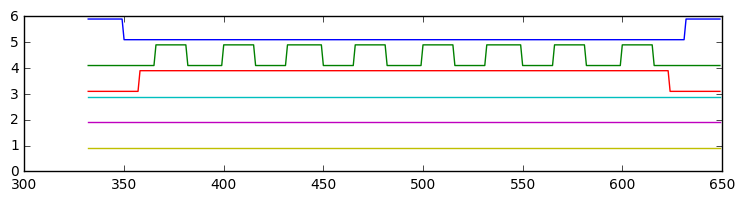


CMD ABh


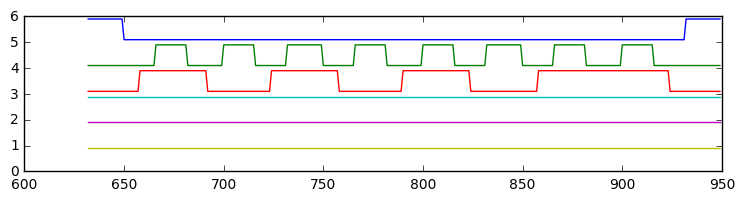


CMD EDh
ADDR 10104Ch
MODE FFh
DATA 00C0006Fh ok


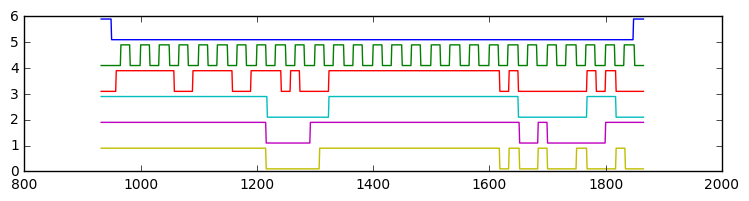


CMD EDh
ADDR 101058h
MODE FFh
DATA D05FF06Fh ok


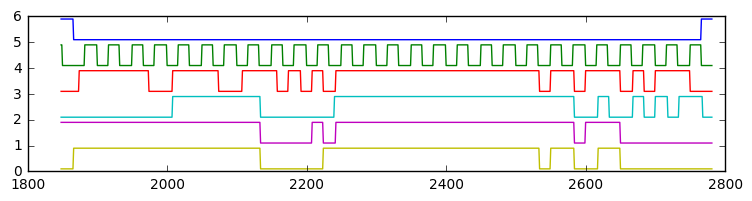


CMD EDh
ADDR 100D5Ch
MODE FFh
DATA 001017B7h ok
DATA 08478513h ok
DATA E58FF0EFh ok


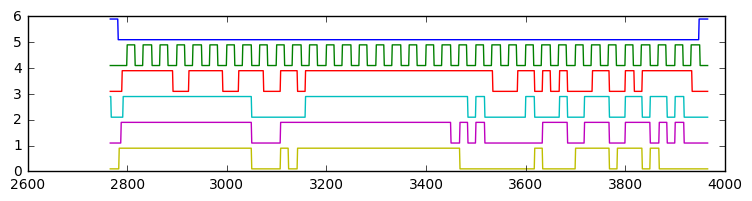


CMD EDh
ADDR 1003BCh
MODE FFh
DATA FE010113h ok
DATA 00112E23h ok
DATA 00812C23h ok
DATA 02010413h ok
DATA FEA42623h ok
DATA 01C0006Fh ok
DATA FEC42783h ok


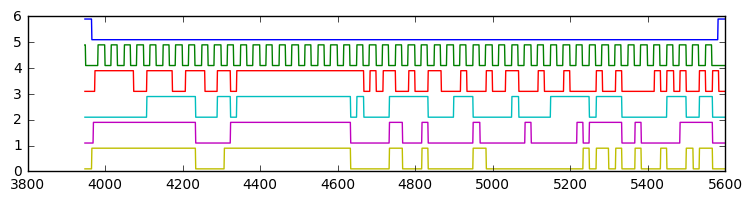


CMD EDh
ADDR 1003F0h
MODE FFh
DATA 0007C783h ok
DATA FE0790E3h ok


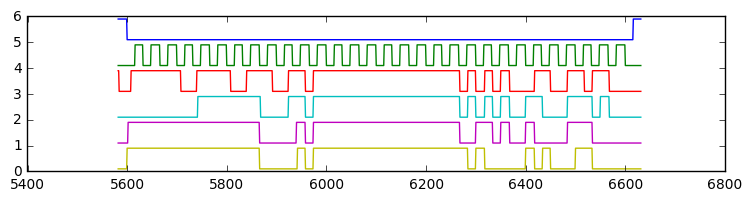


CMD EDh
ADDR 101084h
MODE FFh
DATA 0000000Ah ok


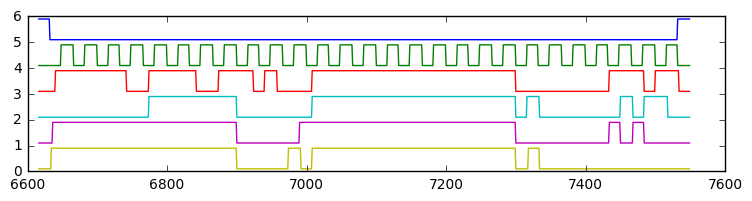


CMD EDh
ADDR 1003F8h
MODE FFh
DATA 00000013h ok


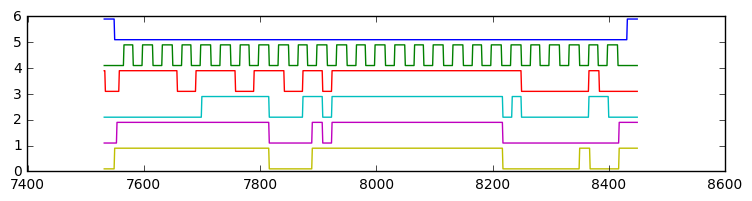


CMD EDh
ADDR 1003D4h
MODE FFh
DATA FEC42783h ok
DATA 00178713h ok
DATA FEE42623h ok
DATA 0007C783h ok
DATA 00078513h ok


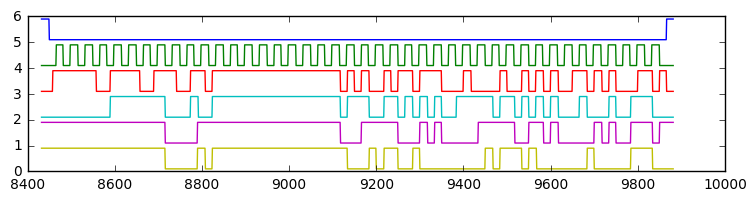


CMD EDh
ADDR 101084h
MODE FFh
DATA 0000000Ah ok


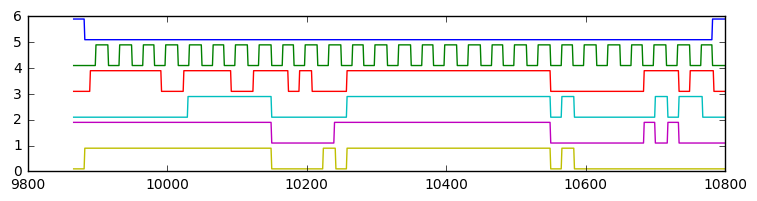


CMD EDh
ADDR 1003E8h
MODE FFh
DATA F85FF0EFh ok


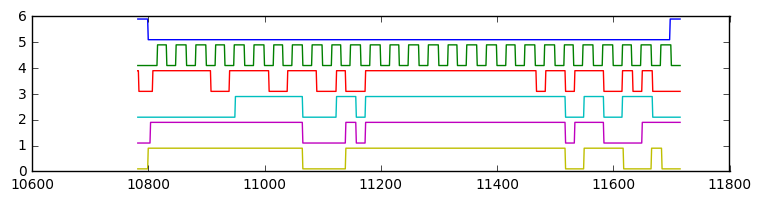


CMD EDh
ADDR 10036Ch
MODE FFh
DATA FE010113h ok
DATA 00112E23h ok
DATA 00812C23h ok
DATA 02010413h ok
DATA 00050793h ok
DATA FEF407A3h ok
DATA FEF44703h ok
DATA 00A00793h ok
DATA 00F71663h ok
DATA 00D00513h ok
DATA FD9FF0EFh ok


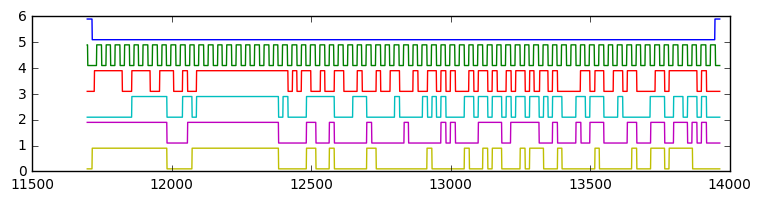


CMD EDh
ADDR 10036Ch
MODE FFh
DATA FE010113h ok
DATA 00112E23h ok
DATA 00812C23h ok
DATA 02010413h ok
DATA 00050793h ok
DATA FEF407A3h ok
DATA FEF44703h ok
DATA 00A00793h ok
DATA 00F71663h ok
DATA 00D00513h ok


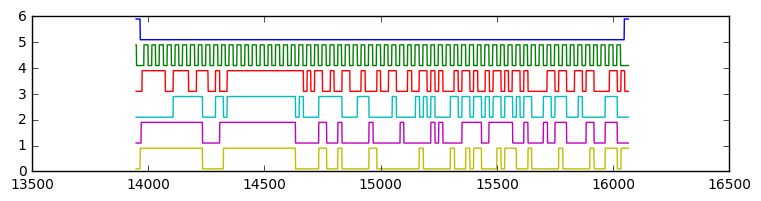


CMD EDh
ADDR 100398h
MODE FFh
DATA 020007B7h ok
DATA 00878793h ok
DATA FEF44703h ok
DATA 00E7A023h ok
DATA 00000013h ok
DATA 01C12083h ok
DATA 01812403h ok
DATA 02010113h ok
DATA 00008067h ok
DATA FE010113h ok


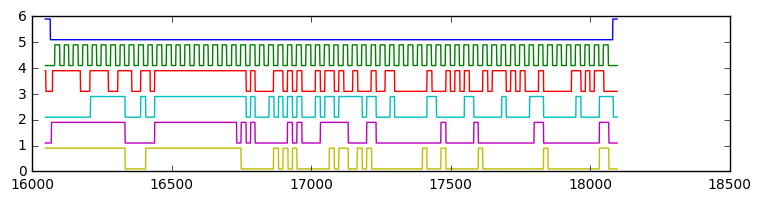


CMD EDh
ADDR 10039Ch
MODE FFh
DATA 00878793h ok
DATA FEF44703h ok
DATA 00E7A023h ok
DATA 00000013h ok
DATA 01C12083h ok

Found 0 errors.


In [2]:
errcount = 0
last_clk = None
clk = None

begin = None
state = None
index = None
cmd = None
addr = None
mode = None
word = None

for i in range(data.shape[0]):
    last_clk = clk
    csb, clk, io0, io1, io2, io3 = [bool(v) for v in data[i, :]]
    
    if csb:
        if state != "wait":
            index = i
        state = "wait"
        continue
    
    if state is None:
        continue

    if state == "wait":
        if not csb:
            if begin is not None:
                plt.figure(figsize=(9, 2))
                for k in range(len(cols)):
                    plt.plot(np.arange(begin, i), 5.1 - k + 0.8*data[begin:i, k], label=cols[k])
                plt.show()
            begin = index
            state = "cmd"
            index = 0
            cmd = 0
        continue
    
    if state == "cmd":
        if not last_clk and clk:
            cmd = (cmd << 1) | (1 if io0 else 0)
            index += 1
        if last_clk and not clk:
            if index == 8:
                print()
                print("CMD %02Xh" % cmd)
                if cmd == 0xED:
                    state = "cmd_ed_addr"
                    addr = 0
                    index = 0
        continue
        
    if state == "cmd_ed_addr":
        if last_clk != clk:
            addr <<= 4
            addr |= 1 if io0 else 0
            addr |= 2 if io1 else 0
            addr |= 4 if io2 else 0
            addr |= 8 if io3 else 0
            index += 4
            if index == 24:
                print("ADDR %06Xh" % addr)
                state = "cmd_ed_mode"
                mode = 0
                index = 0
        continue
        
    if state == "cmd_ed_mode":
        if last_clk != clk:
            mode <<= 4
            mode |= 1 if io0 else 0
            mode |= 2 if io1 else 0
            mode |= 4 if io2 else 0
            mode |= 8 if io3 else 0
            index += 4
            if index == 8:
                print("MODE %02Xh" % mode)
                state = "cmd_ed_dummy"
                index = 0
        continue
    
    if state == "cmd_ed_dummy":
        if not last_clk and clk:
            index += 1
            if index == 8:
                state = "cmd_ed_data"
                word = 0
                index = 0
        continue

    if state == "cmd_ed_data":
        if last_clk != clk:
            io0, io1, io2, io3 = [bool(v) for v in data[i+ddr_delay, 2:]]
            word <<= 4
            word |= 1 if io0 else 0
            word |= 2 if io1 else 0
            word |= 4 if io2 else 0
            word |= 8 if io3 else 0
            index += 4
            if index == 32:
                word = (((word << 24) & 0xFF000000) |
                        ((word <<  8) & 0x00FF0000) |
                        ((word >>  8) & 0x0000FF00) |
                        ((word >> 24) & 0x000000FF))
                if bindata[(addr - 0x100000) // 4] == word:
                    print("DATA %08Xh ok" % word)
                else:
                    print("DATA %08Xh ERROR (bindata[%d]=0x%04x)" %
                          (word, (addr - 0x100000)//4, bindata[(addr - 0x100000)//4]))
                    errcount += 1
                word = 0
                index = 0
                addr += 4
        continue

print()
print("Found %d errors." % errcount)